### Experiments setup

In [1]:
import numpy as np
import pandas as pd
import torch
import torchtuples as tt
from pycox import datasets
from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime

np.random.seed(1234)
_ = torch.manual_seed(123)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
df = datasets.metabric.read_df()
feat_cols = ["x0", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]
feats = df[feat_cols]
surv_label_df = df[["duration", "event"]]

In [3]:
numeric_feat_cols = ["x0", "x1", "x2", "x3", "x8"]
cate_feat_cols = [col for col in feat_cols if col not in numeric_feat_cols]

In [4]:
# Encode categorical features
from sklearn.preprocessing import OneHotEncoder
feats_new = feats[numeric_feat_cols]
feat_enc_cols = []
enc_dict = {}
for feat_col in cate_feat_cols:
    enc = OneHotEncoder(drop='if_binary')
    feat_new = enc.fit_transform(feats[feat_col].values.reshape((-1, 1))).toarray()
    feat_col_new = enc.get_feature_names_out([feat_col]).tolist()
    feats_new[feat_col_new] = feat_new.astype(feats[feat_col].values.dtype)
    feat_enc_cols.append(feat_col_new)
    enc_dict[feat_col] = enc
    
feats = feats_new
feat_cols = feats.columns.values
df = feats.copy(deep=True)
df[["duration", "event"]] = surv_label_df
surv_label = df[["duration", "event"]].values

0:	[0s / 0s],		train_loss: 0.6953,	val_loss: 0.6476
1:	[0s / 0s],		train_loss: 0.6431,	val_loss: 0.6386
2:	[0s / 0s],		train_loss: 0.6351,	val_loss: 0.6339
3:	[0s / 0s],		train_loss: 0.6557,	val_loss: 0.6214
4:	[0s / 0s],		train_loss: 0.6280,	val_loss: 0.6024
5:	[0s / 0s],		train_loss: 0.6209,	val_loss: 0.5916
6:	[0s / 0s],		train_loss: 0.6155,	val_loss: 0.5928
7:	[0s / 0s],		train_loss: 0.6122,	val_loss: 0.5808
8:	[0s / 0s],		train_loss: 0.6385,	val_loss: 0.5832
9:	[0s / 0s],		train_loss: 0.6353,	val_loss: 0.5887
10:	[0s / 1s],		train_loss: 0.6245,	val_loss: 0.5901
11:	[0s / 1s],		train_loss: 0.6096,	val_loss: 0.5931
12:	[0s / 1s],		train_loss: 0.6049,	val_loss: 0.5898
13:	[0s / 1s],		train_loss: 0.6006,	val_loss: 0.5894
14:	[0s / 1s],		train_loss: 0.6174,	val_loss: 0.5743
15:	[0s / 1s],		train_loss: 0.5981,	val_loss: 0.5837
16:	[0s / 1s],		train_loss: 0.6096,	val_loss: 0.5843
17:	[0s / 1s],		train_loss: 0.6043,	val_loss: 0.5861
18:	[0s / 1s],		train_loss: 0.5969,	val_loss: 0.5791
19:

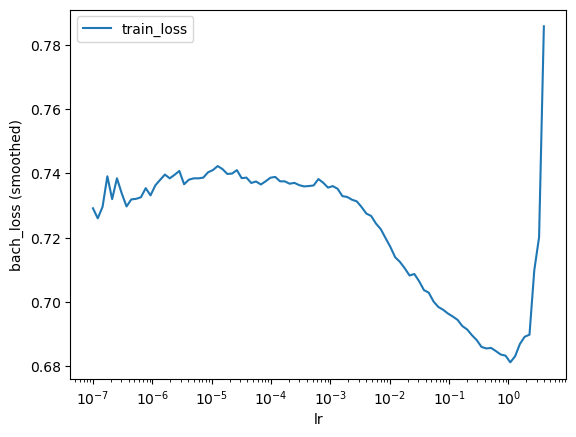

In [5]:
# Split data
df_val = df.sample(frac=0.2)
df_train = df.drop(df_val.index)

x_train = df_train[feat_cols].values
x_val = df_val[feat_cols].values

y_train = (df_train['duration'].values, df_train['event'].values)
y_val = (df_val['duration'].values, df_val['event'].values)
val = tt.tuplefy(x_val, y_val)

# Train the model
in_features = x_train.shape[1]
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1
net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)

estimator = CoxTime(net, tt.optim.Adam)

batch_size = 256
lrfinder = estimator.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

estimator.optimizer.set_lr(0.01)
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

log = estimator.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())

_ = estimator.compute_baseline_hazards()

In [6]:
# Load model explainer
from src.explainer import explainer
model_explainer = explainer(estimator, feats, surv_label, encoders=enc_dict)

### Prediction

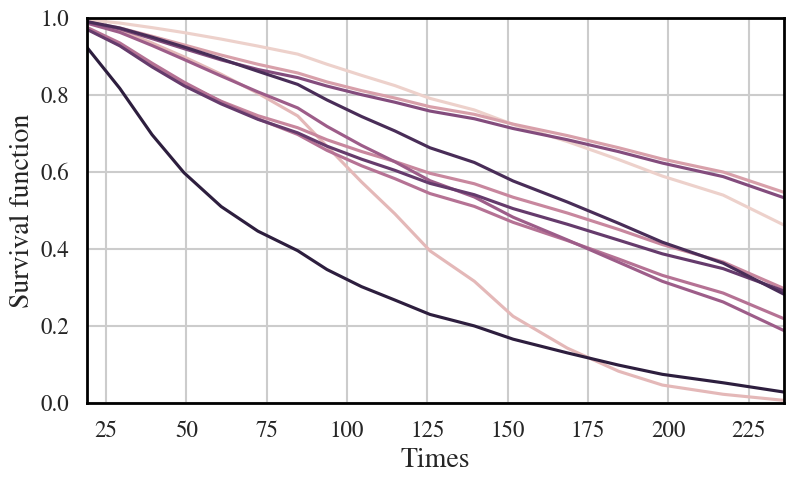

In [7]:
from src import prediction
# select first 10 observations to be explained
explained_data = feats[:10]
# Survival prediction
surv_pred = prediction.predict(model_explainer, explained_data)
prediction.plot_prediction(surv_pred, "survival")

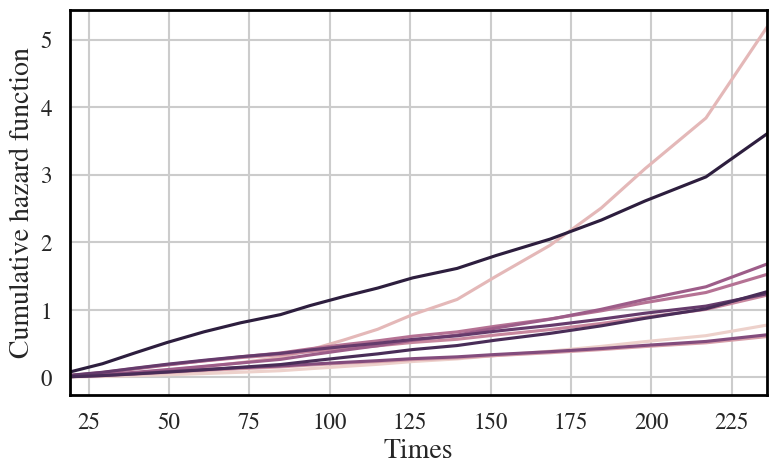

In [8]:
# Cumulative hazard prediction
chf_pred = prediction.predict(model_explainer, explained_data, type="chf")
prediction.plot_prediction(chf_pred, "chf")

### Performance

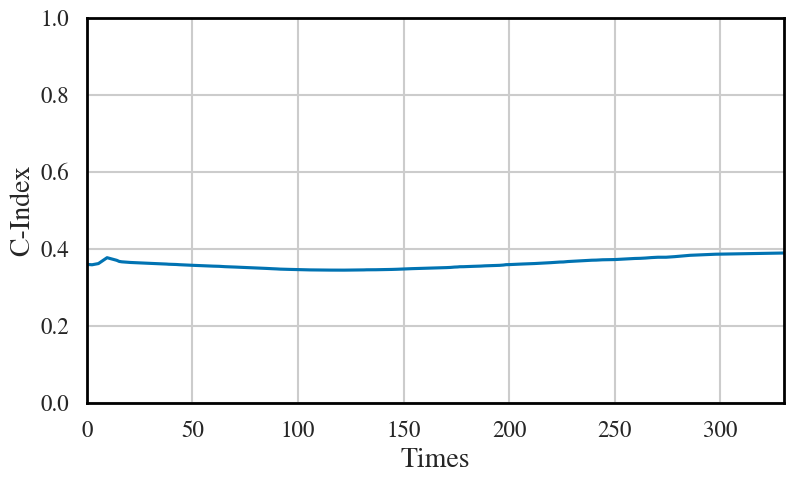

In [9]:
from src import performance
eval_times = np.unique(surv_label[:, 0])[::10]

# C-Index evaluation
cindex_perf = performance.evaluate(model_explainer, feats, surv_label, times=eval_times, metric="c_index")
performance.plot_performance(cindex_perf, metric="c_index")

In [10]:
print(cindex_perf.head(20))

        times      perf
0    0.000000  0.358845
1    2.500000  0.357889
2    5.500000  0.360986
3    9.600000  0.376254
4   11.700000  0.373044
5   14.166667  0.369453
6   15.366667  0.366555
7   16.600000  0.365538
8   18.233334  0.364794
9   19.566668  0.364287
10  20.666666  0.363857
11  21.933332  0.363583
12  23.366667  0.363206
13  24.333334  0.362894
14  25.466667  0.362587
15  27.200001  0.362314
16  28.566668  0.361888
17  29.666666  0.361564
18  30.866667  0.361203
19  31.799999  0.361018


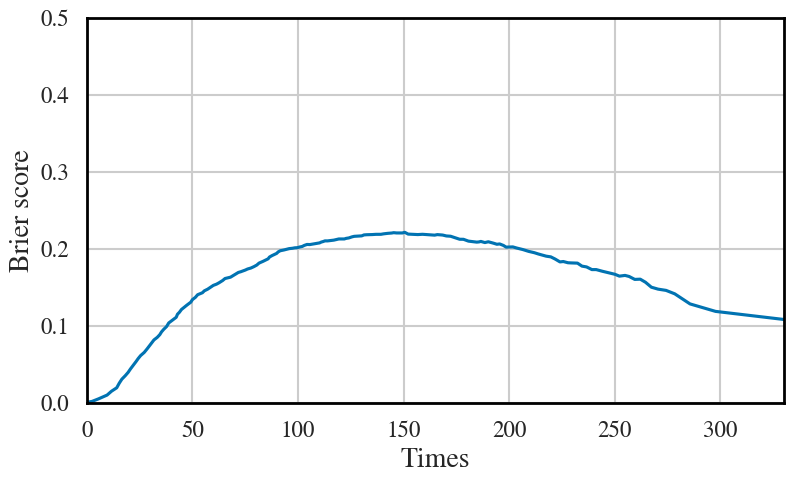

In [11]:
# Brier score evaluation
bs_perf = performance.evaluate(model_explainer, feats, surv_label, times=eval_times, metric="brier_score")
performance.plot_performance(bs_perf, metric="brier_score")

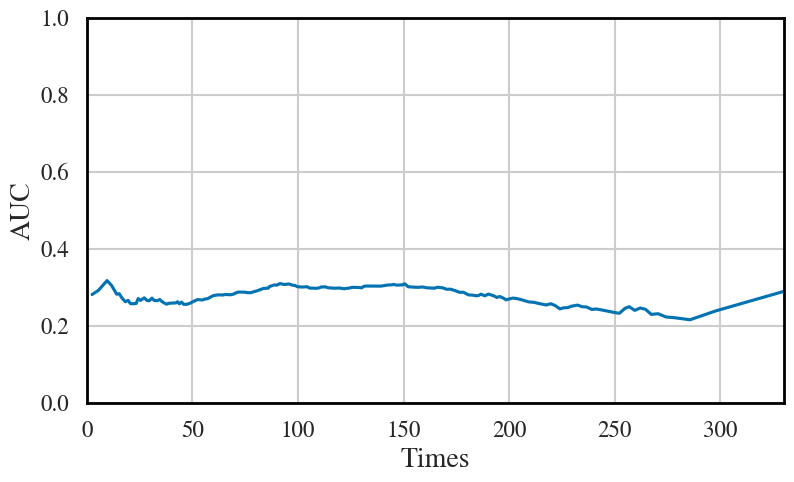

In [12]:
# AUC evaluation
auc_perf = performance.evaluate(model_explainer, feats, surv_label, times=eval_times, metric="auc")
performance.plot_performance(auc_perf, metric="auc")

### Local explaination

In [13]:
from src import local_explaination

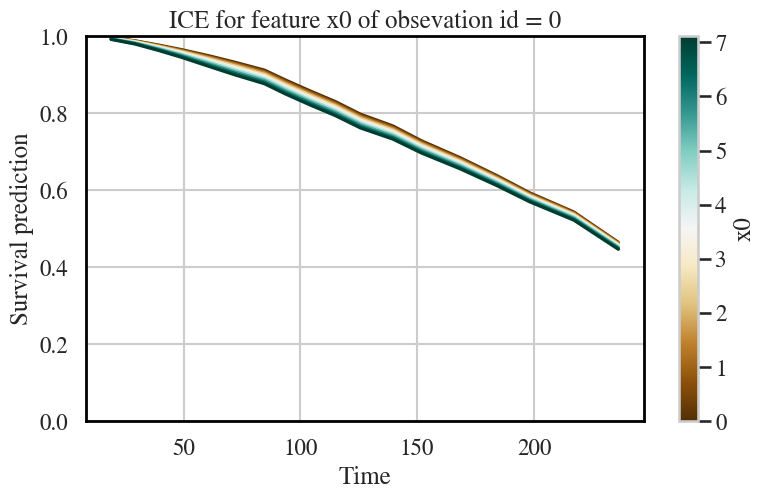

In [14]:
# individual conditional expectation
explained_feature = "x0"
ICE_df = local_explaination.individual_conditional_expectation(model_explainer, 
                                                               explained_feature, 
                                                               n_sel_samples=10, 
                                                               n_grid_points=10)
local_explaination.plot_ICE(model_explainer, ICE_df, explained_feature)

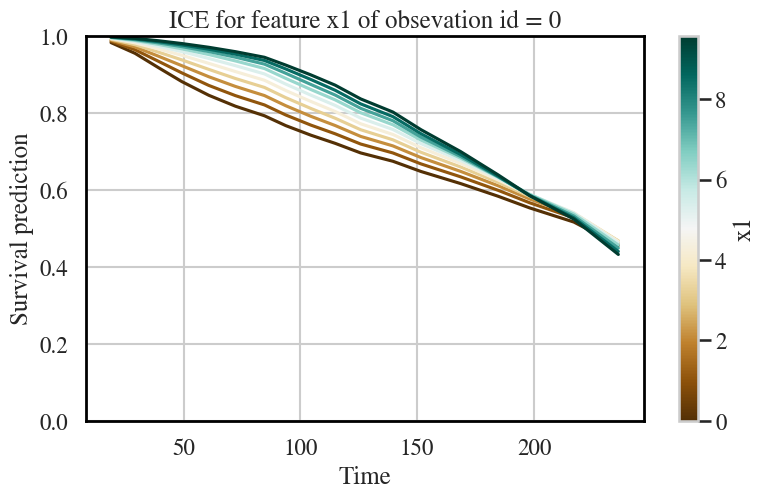

In [15]:
# individual conditional expectation
explained_feature = "x1"
ICE_df = local_explaination.individual_conditional_expectation(model_explainer, 
                                                               explained_feature, 
                                                               n_sel_samples=10, 
                                                               n_grid_points=10)
local_explaination.plot_ICE(model_explainer, ICE_df, explained_feature)

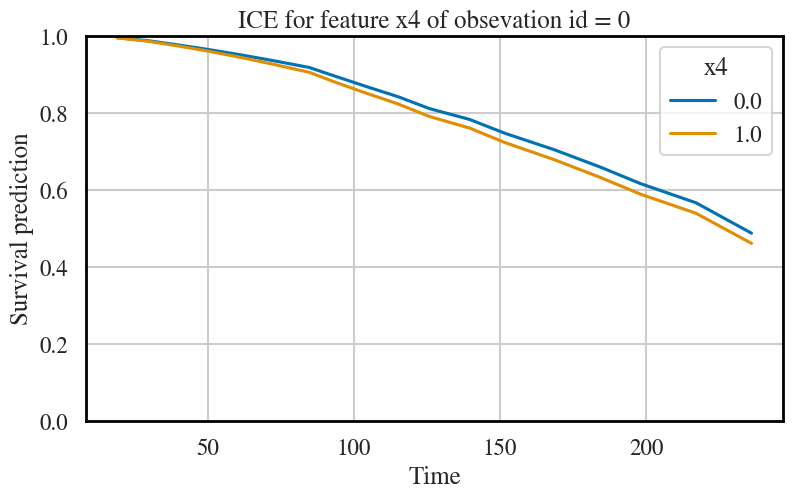

In [16]:
# individual conditional expectation
explained_feature = "x4"
ICE_df = local_explaination.individual_conditional_expectation(model_explainer, 
                                                               explained_feature, 
                                                               n_sel_samples=10, 
                                                               n_grid_points=10)
local_explaination.plot_ICE(model_explainer, ICE_df, explained_feature)

### Global explaination

In [17]:
from src import global_explaination

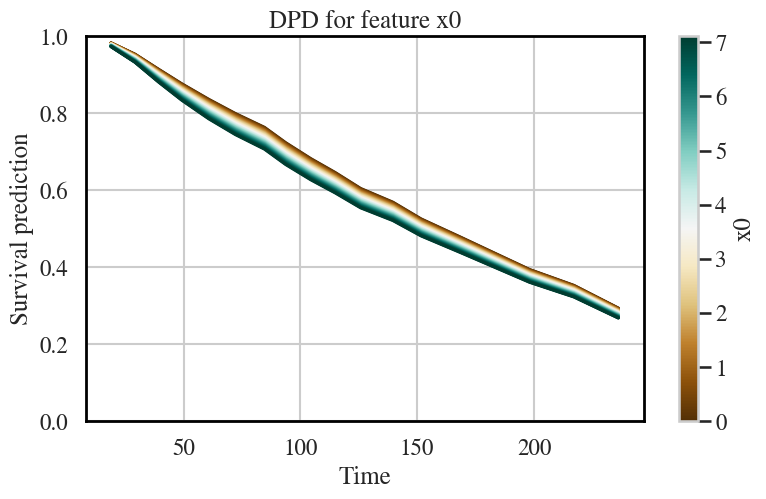

In [18]:
# partial dependence plot
explained_feature = "x0"
PDP_df = global_explaination.partial_dependence_plots(model_explainer, explained_feature, n_sel_samples=10)
global_explaination.plot_PDP(model_explainer, PDP_df, explained_feature)

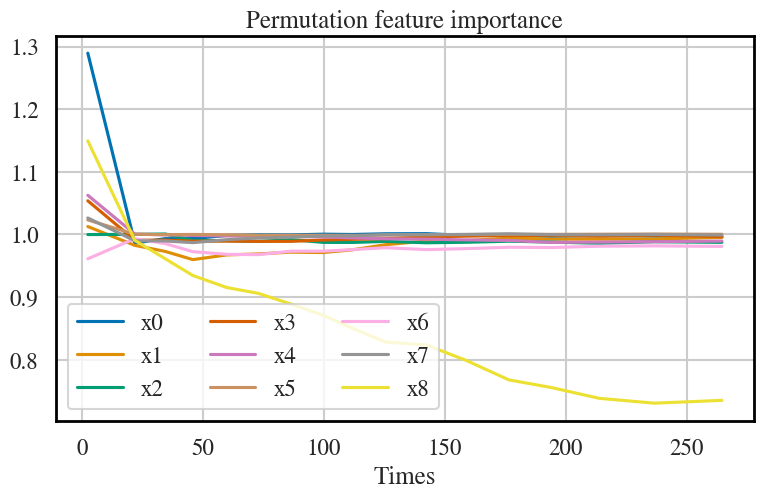

In [19]:
# permuatation feature importance
eval_times = np.unique(surv_label[:, 0])[10::100]
feat_importance_df = global_explaination.permutation_feature_importance(model_explainer, feats, 
                                                                        surv_label, eval_times=eval_times)
global_explaination.plot_PFI(feat_importance_df)